In [ ]:
model_names = ["gpt_gptsw3_en_da_356m_gbs1024","gpt_gptsw3_en_da_is_356m_gbs1024","gpt_gptsw3_en_is_da_356m_gbs1024","gpt_sw3_356m"]

layer = "transformer.h.15.ln_1.bias"
for model_name in model_names:
    
    model_path = "downloaded_models/"

    model, tokenizer, device = model_setup(f"{model_path}{model_name}")
    
    steering = torch.load(f"steering_vectors/{model_name}/combined_steering_vector_layer_15_tensor.pt",map_location = device)
    
    model.state_dict()[layer] += steering
    
    model.save_pretrained(f'{model_path}/{model_name}_with_steering')
    tokenizer.save_pretrained(f'{model_path}/{model_name}_with_steering')  # Optional but recommended

In [ ]:
from refactor.probes import model_setup
import os
from scipy.spatial.distance import euclidean, mahalanobis, cosine
from sklearn.metrics.pairwise import cosine_similarity
import torch
from refactor.utils.hooking import HookManager
from refactor.utils.compatibility import HookAddress
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches





    
       

In [23]:
from refactor.probes import model_setup
import os
from scipy.spatial.distance import euclidean, mahalanobis, cosine
from sklearn.metrics.pairwise import cosine_similarity
import torch
from refactor.utils.hooking import HookManager
from refactor.utils.compatibility import HookAddress

# loads model
print("Load model") 
model_name = "EleutherAI/pythia-14m"
model_name = "AI-Sweden-Models/gpt-sw3-356m"
model, tokenizer, device = model_setup(model_name)


Load model
found device: cuda:0


In [24]:
average_vectors = dict()
path = "average_activation_vectors/gpt_sw3_356m"
layer = 15
for file in os.listdir(path):
    split = file.split("_")
    language = split[1]
    layer_temp = split[3]
    if int(layer_temp) == layer:
        average_vectors[language] = torch.load(path + "/" + file)

C:\Users\tjupp\AppData\Local\Temp\ipykernel_10332\3216484567.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  average_vectors[language] = torch.load(path + "/" + file)


In [36]:
text = "The cat (Felis catus), also referred to as the domestic cat or house cat, is a small domesticated carnivorous mammal. It is the only domesticated species of the family Felidae. Advances in archaeology and genetics have shown that the domestication of the cat occurred in the Near East around 7500 BC."
text = "Tamkatten (Felis catus[1][2] eller Felis silvestris catus[3]) er et lille, tæmmet, kødædende pattedyr oftest med pels. Den kaldes huskat eller bare kat, når der ikke er grund til at skelne den fra andre kattedyr. Katten er værdsat af mennesker for dens selskab og evne til at jage mus og rotter. Mange huskatte bliver op mod 20 år gamle."
if tokenizer.pad_token == None:
    tokenizer.pad_token = tokenizer.eos_token

with HookManager(model) as hook_manager:
    extracted = hook_manager.extract(HookAddress.attention_pre.layer(layer))
    
    tokenized = tokenizer(
                    text,
                    padding=True,
                    truncation=True,
                    return_tensors='pt'
                ).to(device)

    out = model(**tokenized)
    del out

In [37]:
li = []
import torch.nn.functional as F

for token, token_activation in zip(tokenized["input_ids"][0],extracted[0]):
    token_as_word = tokenizer.decode(token).strip()
    #print(token_activation)
    current_max_similarity = 0
    most_similar_language = None
    for language, average_activation in average_vectors.items():
        similarity = F.cosine_similarity(average_activation.cpu().unsqueeze(0), token_activation.cpu().unsqueeze(0))
        print(similarity)
        if current_max_similarity < similarity:
            current_max_similarity = similarity
            most_similar_language = language
    li.append((current_max_similarity,most_similar_language, token_as_word))
        
input_text = li       

tensor([-0.0658])
tensor([-0.0625])
tensor([-0.0674])
tensor([-0.0643])
tensor([-0.0635])
tensor([0.7799])
tensor([0.7798])
tensor([0.7739])
tensor([0.7815])
tensor([0.7826])
tensor([0.7732])
tensor([0.7730])
tensor([0.7598])
tensor([0.7759])
tensor([0.7785])
tensor([0.7998])
tensor([0.8030])
tensor([0.7878])
tensor([0.8022])
tensor([0.8033])
tensor([0.8036])
tensor([0.8042])
tensor([0.7942])
tensor([0.8055])
tensor([0.8054])
tensor([0.7667])
tensor([0.7659])
tensor([0.7563])
tensor([0.7658])
tensor([0.7681])
tensor([0.7893])
tensor([0.7887])
tensor([0.7830])
tensor([0.7883])
tensor([0.7911])
tensor([0.7781])
tensor([0.7798])
tensor([0.7684])
tensor([0.7769])
tensor([0.7806])
tensor([0.7406])
tensor([0.7436])
tensor([0.7349])
tensor([0.7418])
tensor([0.7435])
tensor([0.7895])
tensor([0.7938])
tensor([0.7775])
tensor([0.7925])
tensor([0.7902])
tensor([0.7853])
tensor([0.7886])
tensor([0.7782])
tensor([0.7888])
tensor([0.7876])
tensor([0.8057])
tensor([0.8076])
tensor([0.7936])
tensor([0

In [31]:
input_text

[(0, None, 'The'),
 (tensor([0.7734]), 'en', 'cat'),
 (tensor([0.8046]), 'en', '('),
 (tensor([0.8039]), 'en', 'F'),
 (tensor([0.7660]), 'sv', 'elis'),
 (tensor([0.7944]), 'sv', 'c'),
 (tensor([0.7773]), 'en', 'atus'),
 (tensor([0.8168]), 'en', '),'),
 (tensor([0.8057]), 'en', 'also'),
 (tensor([0.7497]), 'en', 'referred'),
 (tensor([0.7985]), 'en', 'to'),
 (tensor([0.8312]), 'en', 'as'),
 (tensor([0.8415]), 'en', 'the'),
 (tensor([0.8158]), 'en', 'domestic'),
 (tensor([0.7725]), 'en', 'cat'),
 (tensor([0.8278]), 'en', 'or'),
 (tensor([0.8008]), 'en', 'house'),
 (tensor([0.7866]), 'en', 'cat'),
 (tensor([0.8270]), 'en', ','),
 (tensor([0.7950]), 'en', 'is'),
 (tensor([0.8061]), 'en', 'a'),
 (tensor([0.7911]), 'en', 'small'),
 (tensor([0.7693]), 'en', 'dom'),
 (tensor([0.7658]), 'en', 'est'),
 (tensor([0.8134]), 'en', 'icated'),
 (tensor([0.7659]), 'en', 'carn'),
 (tensor([0.7630]), 'en', 'ivor'),
 (tensor([0.8112]), 'en', 'ous'),
 (tensor([0.7761]), 'en', 'mamm'),
 (tensor([0.7716]), '

In [13]:
values = [float(str(t[0]).strip('tensor([])')) for t in input_text]

C:\Users\tjupp\AppData\Local\Temp\ipykernel_10332\1230887955.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((x, y-0.25), word_width, 0.5,


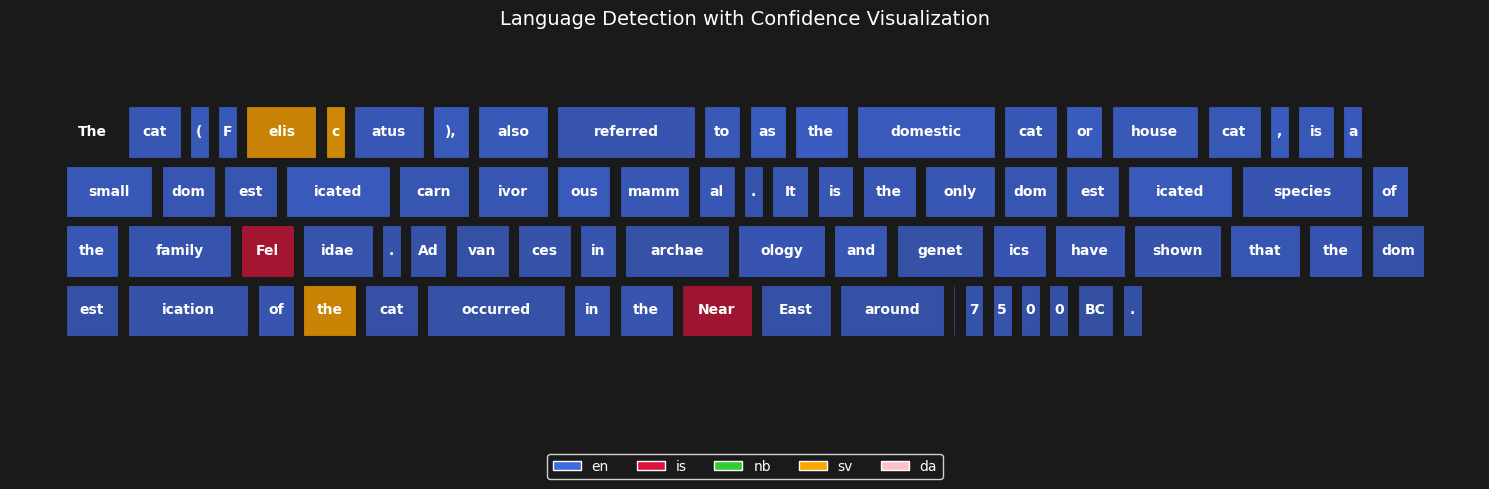